In [1]:
import os
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("data/autofl_base.csv")

print(data.head())

       bug_id  run_id   model  total_messages  function_calls  \
0  Closure_54       9  llama3               9               2   
1  Closure_15       9  llama3              15               5   
2     Math_95       9  llama3               9               2   
3  Closure_42       9  llama3               9               2   
4    Chart_15       9  llama3              11               3   

   valid_function_calls  function_repetitions  function_and_args_repetitions  \
0                     2                     0                              0   
1                     4                     0                              0   
2                     1                     0                              0   
3                     1                     0                              0   
4                     2                     0                              0   

   content_length  success  
0             671    False  
1            1586    False  
2             462    False  
3           

In [10]:
overall_corr = data[
    [
        "total_messages",
        "function_calls",
        "valid_function_calls",
        "function_repetitions",
        "function_and_args_repetitions",
        "content_length",
        "success",
    ]
].corr()

# Extract correlations with success
overall_corr["success"].drop("success")


total_messages                  -0.055068
function_calls                  -0.072988
valid_function_calls             0.142900
function_repetitions            -0.119779
function_and_args_repetitions   -0.118080
content_length                   0.004251
Name: success, dtype: float64

In [9]:
metrics = [
    "total_messages",
    "function_calls",
    "valid_function_calls",
    "function_repetitions",
    "function_and_args_repetitions",
    "content_length",
]

all_corr_results = {}

for model, group in data.groupby("model"):
    corr_dict = {f"corr_{m}_success": group[m].corr(group["success"].astype(int)) for m in metrics}
    all_corr_results[model] = corr_dict

# Convert to DataFrame for display
all_corr_df = pd.DataFrame.from_dict(all_corr_results, orient="index").sort_index()
all_corr_df


,corr_total_messages_success,corr_function_calls_success,corr_valid_function_calls_success,corr_function_repetitions_success,corr_function_and_args_repetitions_success,corr_content_length_success
llama3,-0.028516,-0.073642,0.189651,-0.150763,-0.157881,0.132656
llama3.1,-0.081805,-0.103982,0.151008,-0.153465,-0.152414,-0.001359
mistral-nemo,-0.038272,-0.038694,0.103190,-0.066440,-0.036171,-0.043926
qwen2.5-coder,-0.016240,-0.016261,0.112055,-0.031089,0.003621,0.006036


In [13]:
spearman_corr = data[
    [
        "total_messages",
        "function_calls",
        "valid_function_calls",
        "function_repetitions",
        "function_and_args_repetitions",
        "content_length",
        "success",
    ]
].corr(method="spearman")["success"].drop("success")
print(spearman_corr)

total_messages                  -0.045044
function_calls                  -0.059041
valid_function_calls             0.164158
function_repetitions            -0.118320
function_and_args_repetitions   -0.121924
content_length                   0.059120
Name: success, dtype: float64


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [17]:
X = data[
    [
        "total_messages",
        "function_calls",
        "valid_function_calls",
        "function_repetitions",
        "function_and_args_repetitions",
        "content_length",
    ]
]
y = data["success"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

spearman_corr, accuracy, feature_importances, perm_importances

(total_messages                  -0.045044
 function_calls                  -0.059041
 valid_function_calls             0.164158
 function_repetitions            -0.118320
 function_and_args_repetitions   -0.121924
 content_length                   0.059120
 Name: success, dtype: float64,
 0.6796657381615598,
 content_length                   0.846281
 valid_function_calls             0.053889
 total_messages                   0.030409
 function_repetitions             0.025350
 function_calls                   0.022067
 function_and_args_repetitions    0.022003
 dtype: float64,
 content_length                   0.000108
 valid_function_calls            -0.009858
 function_and_args_repetitions   -0.024497
 function_repetitions            -0.032761
 function_calls                  -0.052940
 total_messages                  -0.057382
 dtype: float64)

/tmp/ipykernel_1561880/1857206916.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate = data.groupby('length_bin')['success'].mean()
/tmp/ipykernel_1561880/1857206916.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = data.groupby('length_bin')['content_length'].mean()


Text(0.5, 1.0, 'Success Probability vs. Content Length')

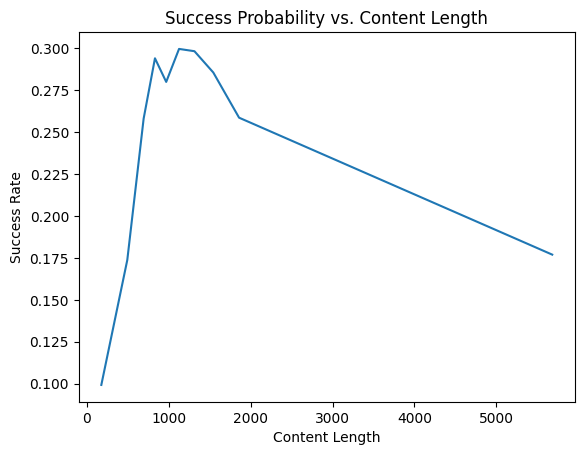

In [19]:
import matplotlib.pyplot as plt
data['length_bin'] = pd.qcut(data['content_length'], q=10)  # 10 quantile bins
success_rate = data.groupby('length_bin')['success'].mean()
bin_centers = data.groupby('length_bin')['content_length'].mean()

plt.plot(bin_centers, success_rate)
plt.xlabel('Content Length')
plt.ylabel('Success Rate')
plt.title('Success Probability vs. Content Length')

/home/coinse/.local/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


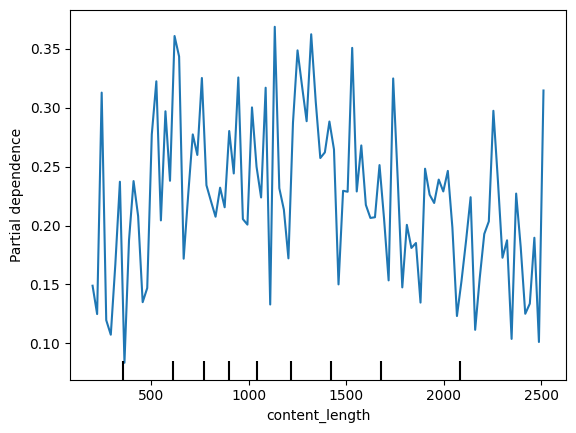

In [20]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, X, ['content_length'])


In [24]:
data["project"] = data["bug_id"].str.split("_").str[0]

project_summary = data.groupby("project").agg(
    avg_content_length=("content_length", "mean"),
    median_content_length=("content_length", "median"),
    success_rate=("success", "mean"),
    count=("success", "size"),
).sort_values("success_rate", ascending=False)

project_summary


,avg_content_length,median_content_length,success_rate,count
project,,,,
cookiecutter,1067.812500,949.5,0.575000,160
youtube,1709.366667,871.5,0.499405,1680
Chart,1205.287201,1046.0,0.417274,961
Lang,1399.191176,1090.5,0.409664,2380
ansible,990.735593,826.0,0.361017,590
Math,1857.403105,1253.5,0.342263,3994
Time,1279.746254,1177.0,0.302697,1001
scrapy,1270.599342,916.0,0.299342,1520
thefuck,892.051077,830.0,0.250599,1253


success,mean_length_fail,mean_length_success
project,,
keras,1811.432947,3573.512270
pandas,1088.103894,1836.563486
Math,1872.637609,1828.126554
youtube,1797.043995,1621.480334
Closure,1650.842039,1383.446667
matplotlib,1834.359170,1243.487069
Time,1298.214900,1237.201320
scrapy,1290.538028,1223.929670
luigi,1365.455375,1215.024793


<Figure size 1200x600 with 0 Axes>

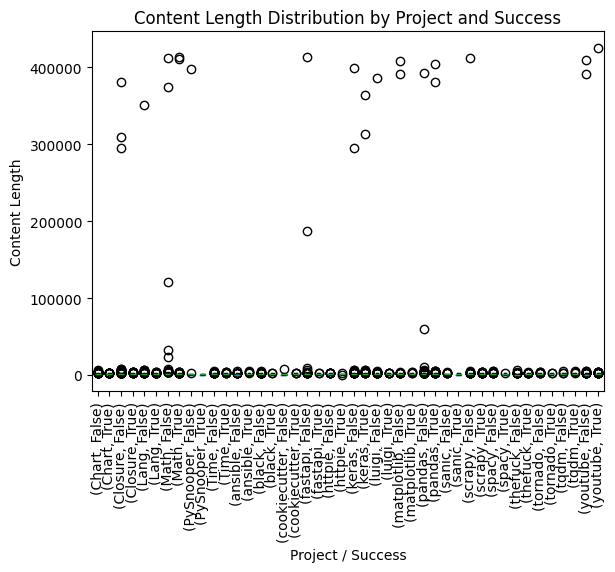

In [25]:
import matplotlib.pyplot as plt

project_success_lengths = (
    data.groupby(["project", "success"])["content_length"]
    .mean()
    .unstack()
    .rename(columns={False: "mean_length_fail", True: "mean_length_success"})
    .sort_values("mean_length_success", ascending=False)
)

plt.figure(figsize=(12, 6))
data.boxplot(column="content_length", by=["project", "success"], grid=False, rot=90)
plt.title("Content Length Distribution by Project and Success")
plt.suptitle("")
plt.ylabel("Content Length")
plt.xlabel("Project / Success")

project_success_lengths.head(10)


<Figure size 3000x600 with 0 Axes>

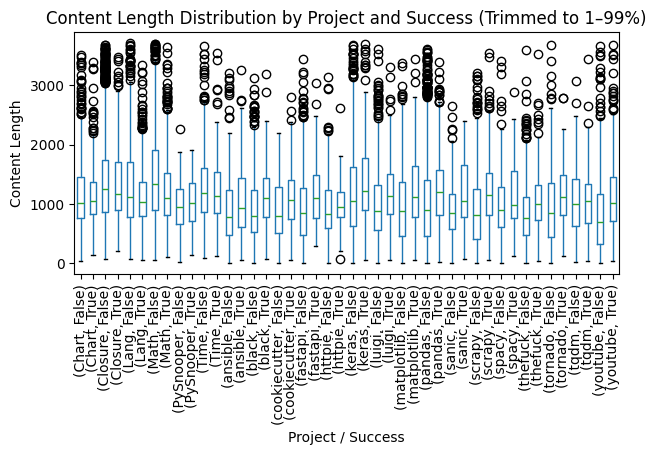

In [32]:
plt.figure(figsize=(30, 6))   # wider plot (was 10)
df_trimmed.boxplot(column="content_length", by=["project", "success"],
                   grid=False, rot=90)
plt.title("Content Length Distribution by Project and Success (Trimmed to 1–99%)")
plt.suptitle("")
plt.ylabel("Content Length")
plt.xlabel("Project / Success")
plt.tight_layout()             
plt.show()

In [34]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 5.1 MB/s eta 0:00:004.9 MB/s eta 0:00:01


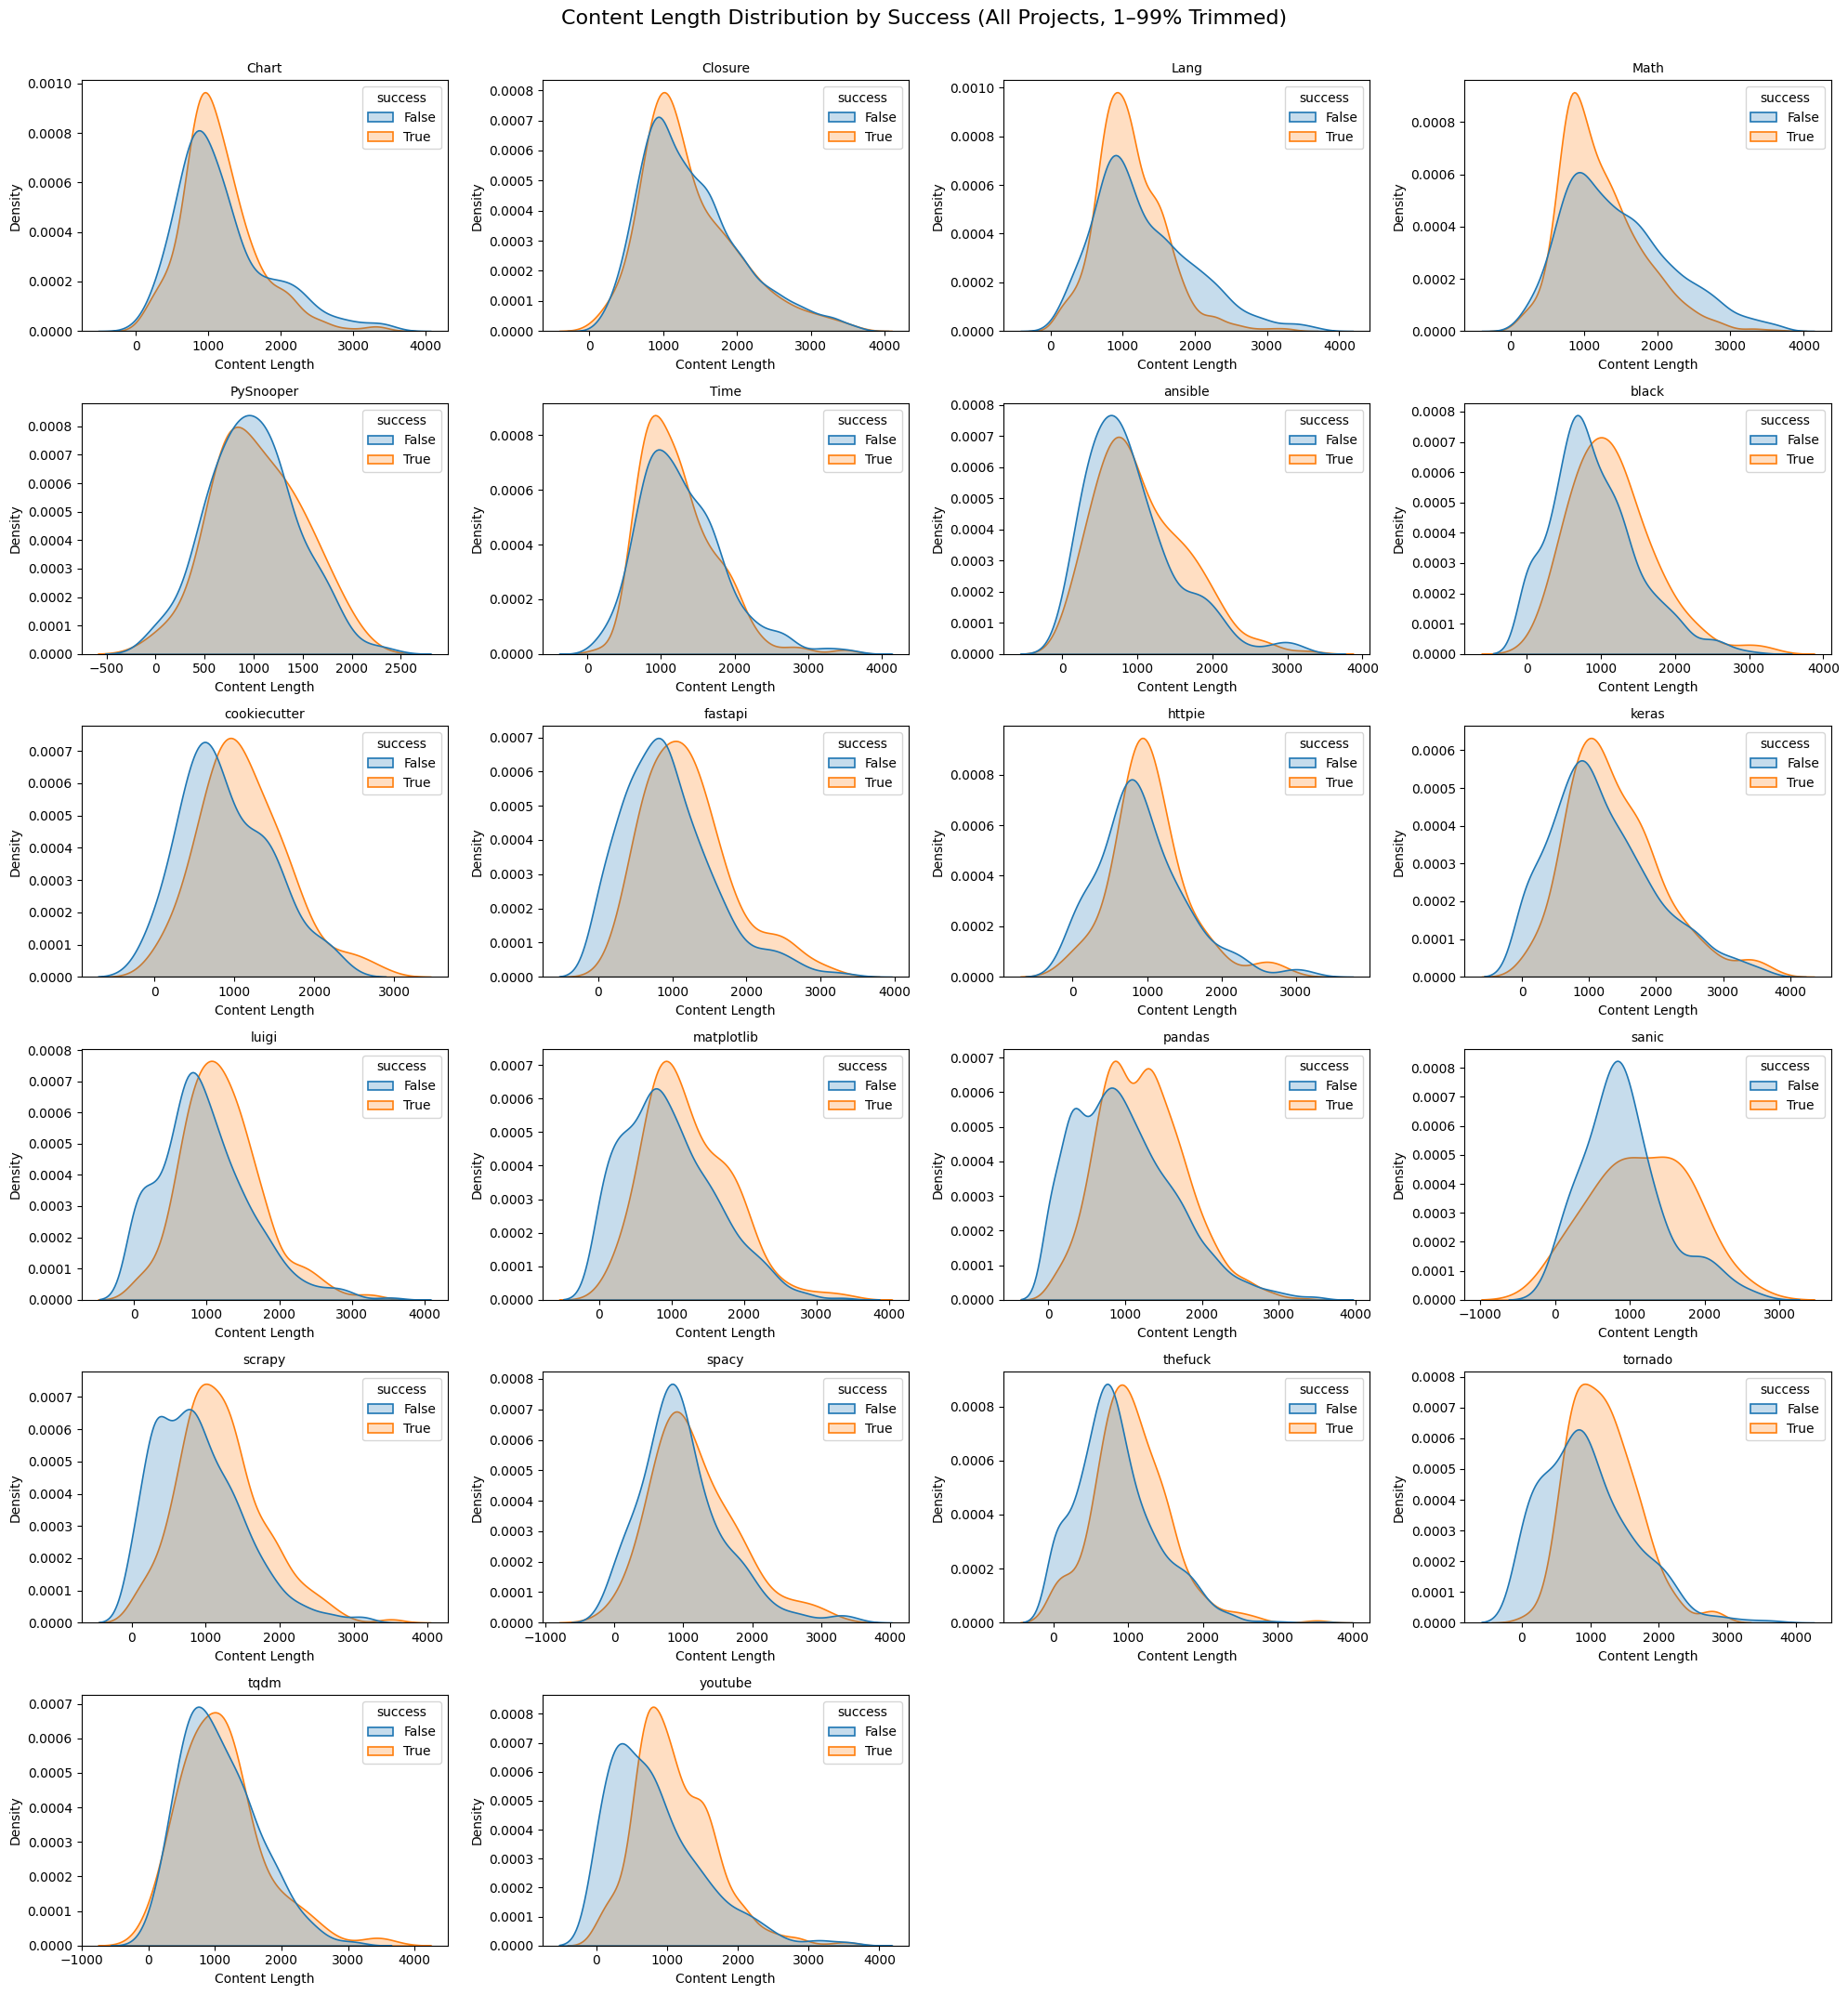

In [36]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

projects = sorted(df_trimmed["project"].unique())
n_projects = len(projects)

cols = 4
rows = math.ceil(n_projects / cols)

plt.figure(figsize=(5 * cols, 3.5 * rows))

for i, project in enumerate(projects, 1):
    plt.subplot(rows, cols, i)
    subset = df_trimmed[df_trimmed["project"] == project]
    sns.kdeplot(data=subset, x="content_length", hue="success",
                common_norm=False, fill=True, linewidth=1.2)
    plt.title(project, fontsize=10)
    plt.xlabel("Content Length")
    plt.ylabel("Density")
    plt.tight_layout()

plt.suptitle("Content Length Distribution by Success (All Projects, 1–99% Trimmed)", fontsize=16, y=1.02)
plt.show()


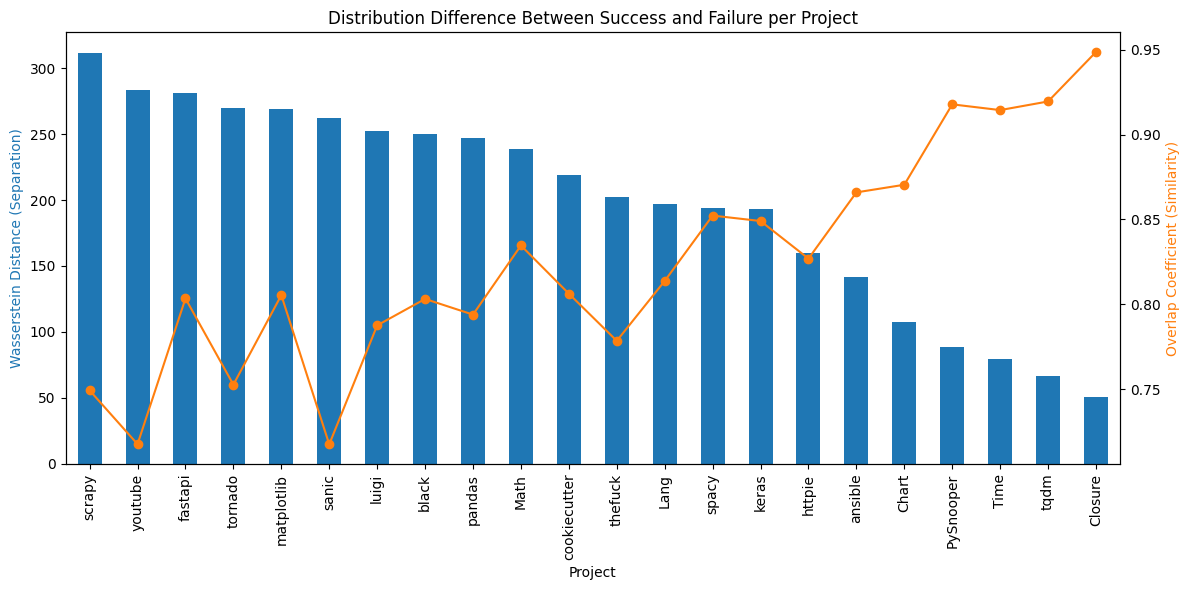

,project,wasserstein_distance,overlap_coefficient
16,scrapy,311.470109,0.749198
21,youtube,283.016303,0.717495
9,fastapi,281.234749,0.803402
19,tornado,269.668782,0.752571
13,matplotlib,269.128931,0.805351
15,sanic,262.160324,0.717395
12,luigi,252.642482,0.787532
7,black,249.897036,0.803111
14,pandas,246.753159,0.793874
3,Math,238.602300,0.834634


In [38]:
from scipy.stats import wasserstein_distance
from scipy.stats import gaussian_kde

def overlap_coefficient(x1, x2):
    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)
    xs = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 500)
    return np.trapz(np.minimum(kde1(xs), kde2(xs)), xs)

project_differences = []

for project, subset in df_trimmed.groupby("project"):
    success_vals = subset.loc[subset["success"], "content_length"]
    fail_vals = subset.loc[~subset["success"], "content_length"]
    if len(success_vals) > 5 and len(fail_vals) > 5:  # ensure enough samples
        w_dist = wasserstein_distance(success_vals, fail_vals)
        overlap = overlap_coefficient(success_vals, fail_vals)
        project_differences.append((project, w_dist, overlap))

diff_df = pd.DataFrame(project_differences, columns=["project", "wasserstein_distance", "overlap_coefficient"])
diff_df = diff_df.sort_values("wasserstein_distance", ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))
diff_df.plot(x="project", y="wasserstein_distance", kind="bar", ax=ax1, color="tab:blue", legend=False)
ax1.set_ylabel("Wasserstein Distance (Separation)", color="tab:blue")
ax1.set_xlabel("Project")
ax1.tick_params(axis="x", rotation=90)

ax2 = ax1.twinx()
diff_df.plot(x="project", y="overlap_coefficient", kind="line", ax=ax2, color="tab:orange", legend=False, marker="o")
ax2.set_ylabel("Overlap Coefficient (Similarity)", color="tab:orange")

plt.title("Distribution Difference Between Success and Failure per Project")
plt.tight_layout()
plt.show()

diff_df.head(10)

